In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess

In [7]:
PATH = "D:/Universite/Term 6/Artificial Intelligence/CAs/Clustering/flower_images/flower_images"
PATH_CSV =  "D:/Universite/Term 6/Artificial Intelligence/CAs/Clustering/flower_images/flower_images/flower_labels.csv"

In [8]:
flower_labels = pd.read_csv(PATH_CSV)

In [18]:
# def read_and_preprocess_images(folder_path, target_size=(224, 224)):
#     images = []
#     datagen = ImageDataGenerator(
#         featurewise_center=True,
#         featurewise_std_normalization=True,
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         horizontal_flip=True)

#     for filename in os.listdir(folder_path):
#         if filename.endswith(".png"):
#             img_path = os.path.join(folder_path, filename)
#             img = cv2.imread(img_path)

#             if img is not None:
#                 img_resized = cv2.resize(img, target_size)
#                 img_augmented = datagen.random_transform(img_resized)
#                 img_preprocessed = vgg16_preprocess(img_augmented)
#                 images.append(img_preprocessed)

#     return np.array(images, dtype=np.float32)


In [9]:
def read_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),  # Adjust brightness
        # saturation_range=(0.8, 1.2)    # Adjust saturation
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                img_resized = cv2.resize(img, target_size)
                img_augmented = datagen.random_transform(img_resized)
                img_preprocessed = preprocess_input(img_augmented)  # Apply VGG16 preprocessing
                images.append(img_preprocessed)

    return np.array(images, dtype=np.float32)

In [11]:
images = read_and_preprocess_images(PATH)
true_labels = flower_labels['label']
base_model = VGG16(weights="imagenet", include_top=False, input_shape=images[0].shape)
base_model.trainable = True
images = preprocess_input(images)
features = base_model.predict(images)
inertia_values = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters = k, n_init = 15)
    kmeans.fit(features.reshape(features.shape[0], -1))
    inertia_values.append(kmeans.inertia_)
kl = KneeLocator(range(1, 13), inertia_values, curve="convex", direction="decreasing")
optimal_k = kl.elbow

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\sklearn\cluster\_kmeans.py:13

In [12]:
print(optimal_k)

4


c:\Users\AsusIran\anaconda3\envs\envname\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


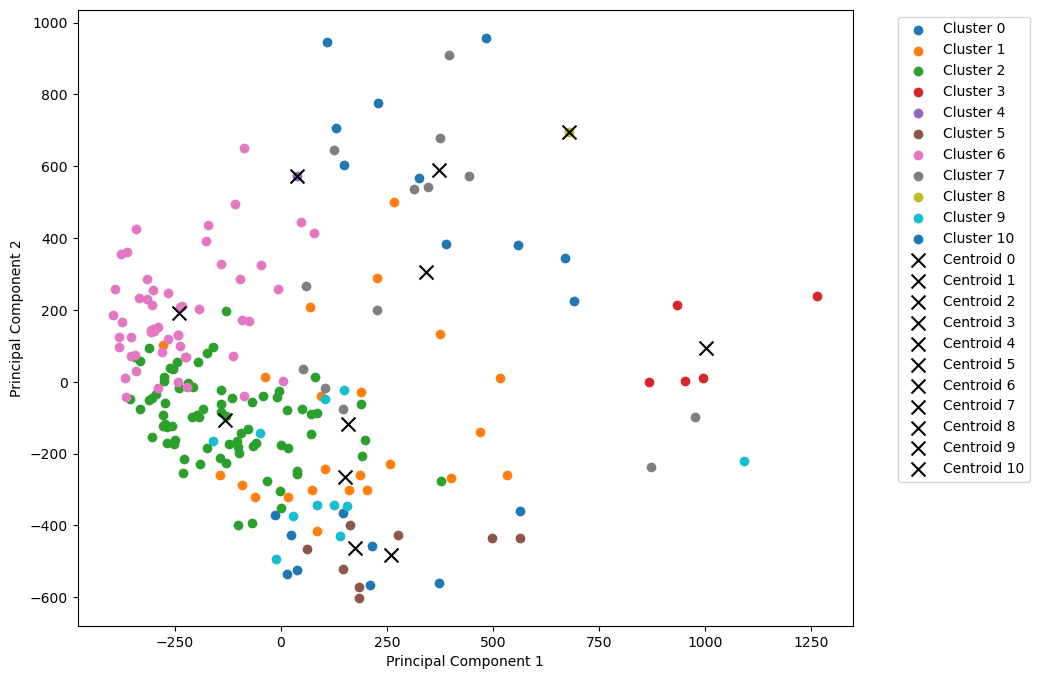

In [25]:
kmeans = KMeans(n_clusters = optimal_k, random_state = 100, n_init = 10)
kmeans.fit(features.reshape(features.shape[0], -1))
y_kmeans = kmeans.predict(features.reshape(features.shape[0], -1))
centers = np.array(kmeans.cluster_centers_)
centroid = pd.DataFrame(centers)
cluster_labels = y_kmeans
pca = PCA(n_components = 2)
pca_features = pca.fit_transform(features.reshape(features.shape[0], -1))
# pca_centers = pca.fit_transform(features.reshape(centers.shape[0], -1))
pca_centers = pca.transform(centers)
def plot_clusters(features, centers, optimal_k):
    plt.figure(figsize=(10, 8))
    for cluster_id in range(optimal_k):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        plt.scatter(features[cluster_indices, 0], features[cluster_indices, 1], label = f'Cluster {cluster_id}')
# Plot the cluster centers
    # for i in range(optimal_k):
    #     plt.scatter(centers[i, 0], centers[i, 1], c = 'black', marker = 'x', s = 100, label = 'Centroids')

    for i, center in enumerate(centers):
        plt.scatter(center[0], center[1], c='black', marker='x', s=100, label=f'Centroid {i}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
plot_clusters(pca_features, pca_centers, optimal_k)

In [26]:
# Calculate silhouette score
silhouette = silhouette_score(features.reshape(features.shape[0], -1), cluster_labels)
print("Silhouette Score for k_means:", silhouette)

# Calculate homogeneity score
homogeneity = homogeneity_score(true_labels, cluster_labels)
print("Homogeneity Score fro k_means:", homogeneity)

Silhouette Score for k_means: 0.016601322
Homogeneity Score fro k_means: 0.23447266219865437
